In [1]:
from qutip import *
import numpy as np
from matplotlib import pyplot as plt

In [2]:
measvec = np.array([1,0])
epsilon = 0.2
Deltas = np.linspace(-6,6,600)
omega = 1.5
T = 2*np.pi/omega  # period of the driving field
n_ph = 13
Vs = [0.05,0.2,1]
# define sigmax and sigmaz
sx = sigmax()
sz = sigmaz()

In [ ]:
#define the Hamiltonian     
# define Hamiltonian: H0 = 0.5*delta*sigma_z + epsilon*sigma_x
H0 = 0.5 * Deltas[0] * sz + epsilon * sx
#Interaction Hamiltonian: Hint = 0.5*Vstr*sigma_z
Hint = Vs[0] * sz

args = {'w': omega}
# Total Hamiltonian: H = H0 + Hint*cos(omega*t)
H = [H0, [Hint, 'cos(w*t)']]
f_basis = FloquetBasis(H, T, args)

f_energies = f_basis.e_quasi
f_modes_0 = f_basis.mode(0)

# psi_g = basis(2,0)

# f_coeff = f_basis.to_floquet_basis(psi_g)

# f_basis.from_floquet_basis(f_coeff)
f_basis.evecs



Dense(shape=(2, 2), fortran=True)

In [4]:
psi_g = basis(2,0)

f_coeff = f_basis.to_floquet_basis(psi_g)

f_basis.from_floquet_basis(f_coeff)
# f_coeff

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.0000000e+00]
 [6.9388939e-18]]

In [ ]:
abs_av = np.zeros((len(Deltas),len(Vs)))

psi_g = basis(2,0)

psi_op = ket2dm(psi_g)

# compute
for iD,Delta in enumerate(Deltas):
    for iV,V in enumerate(Vs):
        # abs_av[iD,iV] = floquet(H0,Hint,omega,n_ph,measvec)

        H0 = 0.5 * Delta * sz + epsilon * sx
        #Interaction Hamiltonian: Hint = 0.5*Vstr*sigma_z
        Hint = V * sz

        args = {'w': omega}
        # Total Hamiltonian: H = H0 + Hint*cos(omega*t)
        H = [H0, [Hint, 'cos(w*t)']]

        f_basis = FloquetBasis(H, T, args)

        f_coeff = f_basis.to_floquet_basis(psi_g)

        psi = f_basis.from_floquet_basis(f_coeff)

        abs_av[iD,iV] = expect(num(2), psi)
print(abs_av)



[[0.72977267 0.72977267 0.72977267]
 [0.72977267 0.72977267 0.72977267]
 [0.72977267 0.72977267 0.72977267]
 ...
 [0.72977267 0.72977267 0.72977267]
 [0.72977267 0.72977267 0.72977267]
 [0.72977267 0.72977267 0.72977267]]


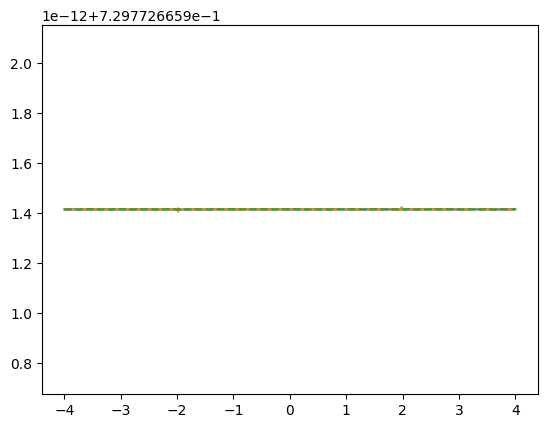

In [10]:

plt.plot(Deltas/omega,abs_av.T[0], label = 'V = '+str(Vs[0]));
plt.plot(Deltas/omega,abs_av.T[1], linestyle = (5,(10,1)), label = 'V = '+str(Vs[1]));
plt.plot(Deltas/omega,abs_av.T[2], '--', label = 'V = '+str(Vs[2]));

plt.show()

In [26]:
import scipy as sp
# number of photons
n_ph = 13
temp_v = np.array([int(k==1) for k in range(n_ph)])
# interaction Hamiltonian
H_int = np.kron(sp.linalg.toeplitz(temp_v),Hint)



In [41]:
import numpy as np
import qutip as qt

def floquet(H0, Hint, omega, n_ph, measvec):
    """Compute the Floquet transition probability using QuTiP tools."""
    
    # Define the photonic number states
    max_ph = int(np.floor(n_ph / 2))
    photon_states = qt.basis(n_ph, max_ph)  # Ground photon state |max_ph⟩

    # Convert Hamiltonians to QObjects
    H0_q = qt.Qobj(H0)
    Hint_q = qt.Qobj(Hint)
    
    # Construct full system Hamiltonian in Floquet basis
    H_atom = qt.tensor(qt.qeye(n_ph), H0_q)
    H_ph = omega * qt.tensor(qt.num(n_ph) - max_ph, qt.qeye(H0_q.shape[0]))  # Shifted photon states
    H_int = qt.tensor(qt.destroy(n_ph) + qt.create(n_ph), Hint_q)  # Interaction

    H = H_atom + H_ph + H_int  # Total Hamiltonian

    # Compute Floquet modes and quasienergies
    T = 2 * np.pi / omega  # Driving period
    # f_modes, f_energies = qt.floquet.floquet_modes(H, T)
    f_basis = FloquetBasis(H, T, args)
    f_modes = f_basis.mode(0)
    # Ground state of the full system
    psi_g = qt.tensor(photon_states, H0_q.eigenstates()[1][-1])  # Ground state tensor product

    # Initialize overlap probability
    overlap_prob = 0

    # Measurement state preparation
    measvec_q = qt.Qobj(measvec)  # Convert measurement vector
    for k_c in range(1, n_ph + 1):
        psi_m = qt.tensor(qt.basis(n_ph, k_c), measvec_q)  # Measurement state
        
        for f_mode in f_modes:
            overlap = psi_m.dag() * f_mode * psi_g  # Overlap calculation
            overlap_prob += np.abs(overlap.full()[0, 0])**2  # Convert to probability
    
    return overlap_prob


In [42]:
import matplotlib.pyplot as plt
from tqdm import tqdm
# input
measvec = np.array([1,0])
epsilon = 0.2
Deltas = np.linspace(-6,6,600)
omega = 1.5
n_ph = 13
Vs = [0.05,0.2,1]
sx,sz = np.array([[0,1],[1,0]]), np.array([[1,0],[0,-1]])
# allocate memory
abs_av = np.zeros((len(Deltas),len(Vs)))
spec = np.zeros((2,len(Deltas)))
# compute
for iD,Delta in enumerate(tqdm(Deltas)):
    for iV,V in enumerate(Vs):
        H0 = Delta/2*sz + epsilon*sx
        evals_un,evecs_un = sp.sparse.linalg.eigsh(H0)
        # sort
        evals = np.sort(evals_un)
        evecs = evecs_un[:, evals_un.argsort()]
        spec[:,iD] = np.sort(evals)
        Hint = V*sz/2
        abs_av[iD,iV] = floquet(H0,Hint,omega,n_ph,measvec)
fig, ax = plt.subplots(2,1, figsize=(8,5))
ax[0].plot(Deltas/omega,spec[1], 'b-', label = r'$\lambda_e$')
ax[0].plot(Deltas/omega,spec[0], 'r-', label = r'$\lambda_g$')
ax[0].legend();
ax[0].set_ylabel(r'Energy');
ax[0].vlines([k for k in range(-3,3+1) if k != 0],-4,4,
linestyles='dashed',linewidths=1, colors = 'black', alpha = 0.5)
ax[1].vlines([k for k in range(-3,3+1) if k != 0],0,1,
linestyles='dashed',linewidths=1, colors = 'black', alpha = 0.5)
ax[1].plot(Deltas/omega,abs_av.T[0], label = 'V = '+str(Vs[0]));
ax[1].plot(Deltas/omega,abs_av.T[1], linestyle = (5,(10,1)), label = 'V = '+str(Vs[1]));
ax[1].plot(Deltas/omega,abs_av.T[2], '--', label = 'V = '+str(Vs[2]));
ax[1].legend();
ax[1].set_xlabel(r'detuning ($\delta$)');
ax[1].set_ylabel(r'Absorption probability');

  0%|          | 0/600 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_5768\1120067944.py:18: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  evals_un,evecs_un = sp.sparse.linalg.eigsh(H0)
  0%|          | 0/600 [00:00<?, ?it/s]


ValueError: All basis indices must be integers in the range `0 <= n < dimension`.